In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np

# --- Core Chebyshev Functions for the KAN Layer ---

# This must include the critical CLIPPING logic discussed
def compute_chebyshev_basis(x, a, b, degree):
    """
    Maps x -> [-1, 1] and computes Chebyshev polynomials recursively.
    Crucially, it clips x to [a, b] to prevent recursion explosion outside domain.
    """
    # Map x to [-1, 1]
    x_scaled = 2.0 * (x - a) / (b - a) - 1.0
    # --- CRITICAL STEP FOR EXTENSIONS ---
    # Clip to avoid NaNs in recursive loops outside [-1, 1]
    x_scaled = jnp.clip(x_scaled, -1.0, 1.0)
    
    basis = [jnp.ones_like(x_scaled), x_scaled]
    for _ in range(2, degree + 1):
        next_t = 2.0 * x_scaled * basis[-1] - basis[-2]
        basis.append(next_t)
    return jnp.stack(basis, axis=-1)

def get_cheby_nodes(a, b, degree):
    """Gauss-Lobatto points mapped to [a, b]"""
    i = jnp.arange(degree + 1)
    nodes_11 = jnp.cos(jnp.pi * i / degree)
    # Map from [-1, 1] to [a, b]
    # Reverse order to keep points increasing for plotting clarity
    nodes_11 = nodes_11[::-1] 
    return a + (nodes_11 + 1.0) * (b - a) / 2.0

def forward_pass(x, weights, a, b, degree):
    """Simplified forward pass: y = sum(weights * basis)"""
    basis = compute_chebyshev_basis(x, a, b, degree)
    # Shape math: (N_pts, degree+1) * (degree+1,) -> (N_pts,)
    return jnp.sum(basis * weights, axis=-1)

# --- The Summation Refit Logic ("The Summation Way") ---

def cheby_summation_refit(old_weights, old_a, old_b, new_a, new_b, degree):
    """
    Refits coefficients from old domain [a, b] to new domain [new_a, new_b]
    using the Discrete Cosine Transform property.
    """
    N = degree
    # 1. Find the Gauss-Lobatto anchor points in the NEW (larger or smaller) domain
    new_nodes = get_cheby_nodes(new_a, new_b, N)
    
    # 2. Evaluate the OLD model at these NEW nodes.
    # Because forward_pass clips x to [old_a, old_b], any nodes in
    # 'new_nodes' outside that old domain will return the boundary values.
    y_targets = forward_pass(new_nodes, old_weights, old_a, old_b, N)
    
    # 3. DCT-I Summation Formula
    # Prepare endpoints (boundary conditions) by scaling by 0.5 (Trapezoidal weight)
    # Since nodes were reversed in get_cheby_nodes, [0] is min, [-1] is max
    y_targets_scaled = y_targets.at[0].multiply(0.5)
    y_targets_scaled = y_targets_scaled.at[-1].multiply(0.5)
    
    # Precompute the DCT matrix (constant matrix multiplication)
    # k = degree index, j = node index
    k_idx = jnp.arange(N + 1)
    j_idx = jnp.arange(N + 1)
    dct_matrix = jnp.cos(k_idx[:, None] * j_idx[None, :] * jnp.pi / N)
    
    # Summation step (Matrix-Vector product)
    new_weights = (2.0 / N) * jnp.matmul(dct_matrix, y_targets_scaled)
    
    # Normalization fix for the bias (T0) term in DCT-I
    new_weights = new_weights.at[0].multiply(0.5)
    
    return new_weights, new_nodes, y_targets

def cheby_exact_lstsq_refit(old_weights, old_a, old_b, new_a, new_b, degree, n_pts=100):
    """
    Performs a robust Linear Least Squares refit for a 1D Chebyshev curve.
    """
    # 1. Create a dense sampling grid in the NEW domain [new_a, new_b]
    x_new = jnp.linspace(new_a, new_b, n_pts)
    
    # 2. Evaluate the OLD model at these NEW points
    # This captures the 'ground truth' including the clipped flat regions
    y_targets = forward_pass(x_new, old_weights, old_a, old_b, degree)
    
    # 3. Construct the Vandermonde matrix for the NEW domain
    # We map the points to the standard [-1, 1] range relative to the new boundaries
    x_standardized = 2.0 * (x_new - new_a) / (new_b - new_a) - 1.0
    
    # helper to get basis without internal domain clipping
    def get_phi(x_std, deg):
        phi = [jnp.ones_like(x_std), x_std]
        for _ in range(2, deg + 1):
            phi.append(2.0 * x_std * phi[-1] - phi[-2])
        return jnp.stack(phi, axis=-1)
    
    Phi = get_phi(x_standardized, degree)

    # 4. Solve the Linear Least Squares problem: Phi @ c = y_targets
    # This finds the coefficients that best approximate the old shape in the new space
    new_weights, _, _, _ = jnp.linalg.lstsq(Phi, y_targets)
    
    return new_weights, x_new, y_targets

def cheby_transfer_matrix_refit(old_weights, a, b, new_a, new_b, degree):
    """
    Exact coefficient transformation via Change of Basis matrix.
    w_new = M @ w_old
    """
    N = degree
    # 1. Get Gauss-Lobatto nodes in the NEW domain (standard [-1, 1] for basis)
    i = jnp.arange(N + 1)
    nodes_std = jnp.cos(jnp.pi * i / N)
    
    # 2. Map these standard 'new' nodes back to the 'old' coordinate system
    # This tells us where the new grid sits relative to the old grid
    # Physical x = new_a + (nodes_std + 1)/2 * (new_b - new_a)
    x_phys = new_a + (nodes_std + 1.0) * (new_b - new_a) / 2.0
    
    # Map physical x to the OLD standardized range [-1, 1]
    x_old_std = 2.0 * (x_phys - a) / (b - a) - 1.0
    
    # 3. Build the Transfer Matrix M
    # M_ij = Value of T_j (old basis) at the locations of the new nodes
    # compute_chebyshev_basis_direct is the recurrence loop without clipping
    M = compute_chebyshev_basis_direct(x_old_std, N) # (N+1, N+1)
    
    # 4. Solve for the new weights
    # Since we evaluated the OLD basis at NEW node locations, 
    # we use the summation property (DCT) to get the new coefficients.
    # We can also use jnp.linalg.solve(Phi_standard, M @ old_weights)
    Phi_std = compute_chebyshev_basis_direct(nodes_std, N)
    
    # For this 1D visualization:
    target_y = jnp.matmul(M, old_weights)
    new_weights = jnp.linalg.solve(Phi_std, target_y)
    
    return new_weights

def soft_clip(x, a, b, stiffness=20.0):
    """
    Replaces jnp.clip with a smooth transition.
    A higher stiffness makes it look more like a hard clip but smoother.
    """
    # Map x to [-1, 1] relative to [a, b]
    mid = (a + b) / 2
    span = (b - a) / 2
    z = (x - mid) / span
    # Use tanh to smoothly plateau at -1 and 1
    return mid + span * jnp.tanh(stiffness * z) / jnp.tanh(stiffness)

def cheby_transfer_matrix_soft_refit(old_weights, a, b, new_a, new_b, degree):
    N = degree
    # 1. Get Gauss-Lobatto nodes in the NEW domain
    i = jnp.arange(N + 1)
    nodes_std = jnp.cos(jnp.pi * i / N)
    x_phys = new_a + (nodes_std + 1.0) * (new_b - new_a) / 2.0
    
    # 2. Soft-Clip the physical points before evaluating the old basis
    # This prevents the 'explosion' at the ends by rounding the transition
    x_phys_soft = soft_clip(x_phys, a, b, stiffness=2.0)
    
    # 3. Standard Transfer Matrix Logic using the soft-clipped points
    x_old_std = 2.0 * (x_phys_soft - a) / (b - a) - 1.0
    
    # Build transfer matrix M and standard basis Phi
    M = compute_chebyshev_basis_direct(x_old_std, N)
    Phi_std = compute_chebyshev_basis_direct(nodes_std, N)
    
    target_y = jnp.matmul(M, old_weights)
    new_weights = jnp.linalg.solve(Phi_std, target_y)
    
    return new_weights

def cheby_transfer_matrix_corrected(old_weights, a, b, new_a, new_b, degree):
    N = degree
    # 1. Get Gauss-Lobatto nodes in the NEW domain (standardized to [-1, 1])
    i = jnp.arange(N + 1)
    nodes_std = jnp.cos(jnp.pi * i / N)
    
    # 2. Map these NEW nodes back to the OLD standardized range [-1, 1]
    # x_phys = new_a + (nodes_std + 1) * (new_b - new_a) / 2
    # x_old_std = 2 * (x_phys - a) / (b - a) - 1
    # Simplified composite mapping:
    ratio = (new_b - new_a) / (b - a)
    center_shift = (2 * new_a - (a + b) + (new_b - new_a)) / (b - a)
    x_old_std = nodes_std * ratio + center_shift
    
    # 3. Apply Soft-Clip ONLY if expanding
    is_expanding = (new_a < a) | (new_b > b)
    # Use jax.lax.cond for JIT-compatible logic
    x_mapped = jnp.where(is_expanding, jnp.tanh(10.0 * x_old_std), x_old_std)
    x_mapped = jnp.clip(x_mapped, -1.0, 1.0)
    
    # 4. Build the Basis Transformation Matrix
    # We evaluate the OLD basis functions at the mapped NEW node locations
    M = compute_chebyshev_basis_direct(x_mapped, N)
    
    # 5. Transform weights: c_new = (Phi_new^-1) @ M @ c_old
    # Phi_new is the basis evaluated at its own standard nodes
    Phi_std = compute_chebyshev_basis_direct(nodes_std, N)
    
    target_y = jnp.matmul(M, old_weights)
    new_weights = jnp.linalg.solve(Phi_std, target_y)
    
    return new_weights

def cheby_summation_refit(old_weights, old_a, old_b, new_a, new_b, degree):
    N = degree
    # 1. Get Gauss-Lobatto nodes in the NEW domain
    i = jnp.arange(N + 1)
    nodes_std = jnp.cos(jnp.pi * i / N)
    x_phys = new_a + (nodes_std + 1.0) * (new_b - new_a) / 2.0
    
    # 2. Evaluate OLD function at NEW nodes (Forward Pass)
    # Ensure this uses jnp.clip(x, old_a, old_b) to prevent 'explosion'
    y_targets = forward_pass(x_phys, old_weights, old_a, old_b, N)
    
    # 3. Analytic Summation (DCT-I Formula)
    # Scale endpoints for orthogonality
    y_targets = y_targets.at[0].multiply(0.5)
    y_targets = y_targets.at[-1].multiply(0.5)
    
    # Precomputed constant DCT matrix
    k_idx = jnp.arange(N + 1)
    j_idx = jnp.arange(N + 1)
    dct_matrix = jnp.cos(k_idx[:, None] * j_idx[None, :] * jnp.pi / N)
    
    # Result: Pure matrix multiplication, no inversion
    new_weights = (2.0 / N) * jnp.matmul(dct_matrix, y_targets)
    new_weights = new_weights.at[0].multiply(0.5)
    
    return new_weights, x_phys, y_targets

def cheby_summation_oversampled_refit(old_weights, old_a, old_b, new_a, new_b, degree, oversample_ratio=1.5):
    N = degree
    M = int(N * oversample_ratio) # Sample more points than we have coefficients
    
    # 1. Get M Gauss-Lobatto nodes in the NEW domain
    i = jnp.arange(M + 1)
    nodes_std = jnp.cos(jnp.pi * i / M)
    x_phys = new_a + (nodes_std + 1.0) * (new_b - new_a) / 2.0
    
    # 2. Evaluate OLD function at these M nodes
    # Using the original weights and bounds captures the 'Retention' data
    y_targets = forward_pass(x_phys, old_weights, old_a, old_b, N)
    
    # 3. Discrete Least Squares via DCT logic
    # Scale endpoints for the trapezoidal rule weights
    weights_vec = jnp.ones(M + 1)
    weights_vec = weights_vec.at[0].set(0.5)
    weights_vec = weights_vec.at[-1].set(0.5)
    
    # Normalize targets
    y_weighted = y_targets * weights_vec
    
    # 4. Generate the Projection Matrix (Size: N+1 x M+1)
    k_idx = jnp.arange(N + 1)
    j_idx = jnp.arange(M + 1)
    # Cosine basis: cos(k * pi * j / M)
    projection = jnp.cos(k_idx[:, None] * j_idx[None, :] * jnp.pi / M)
    
    # 5. Calculate New Coefficients
    new_weights = (2.0 / M) * jnp.matmul(projection, y_weighted)
    
    # Apply the standard Chebyshev c0 scaling
    new_weights = new_weights.at[0].multiply(0.5)
    
    return new_weights, x_phys, y_targets

# --- Visualization Code ---
def calculate_refit_metrics(y_true, y_pred):
    """Calculates RMSE for a single refit result."""
    mse = jnp.mean(jnp.square(y_true - y_pred))
    return jnp.sqrt(mse)

def visualize_all_methods():
    key = jax.random.key(42)
    DEGREE = 5 # Keeping degree lower for better visibility of differences
    N_PLOT_PTS = 1000
    
    old_a, old_b = -2.0, 2.0
    weights = jax.random.normal(key, (DEGREE + 1,)) * 0.5
    
    # Range to view
    x_view = jnp.linspace(-4, 4, N_PLOT_PTS)
    y_orig = forward_pass(x_view, weights, old_a, old_b, DEGREE)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    # High contrast colors and styles
    styles = {
        'orig': {'color': 'black', 'ls': '--', 'lw': 1.5, 'label': 'Original (Target)'},
        'no_refit': {'color': 'red', 'ls': '-', 'lw': 2, 'label': 'No Refit (Scaling)'},
        'lstsq': {'color': 'cyan', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'label': 'LSTSQ Refit'},
        'transfer': {'color': 'magenta', 'ls': ':', 'lw': 3, 'label': 'Transfer Matrix (Exact)'}
    }

    for i, (new_a, new_b) in enumerate([(-4.0, 4.0), (-1.0, 1.0)]):
        ax = axes[i]
        
        # 1. No Refit
        y_no_refit = forward_pass(x_view, weights, new_a, new_b, DEGREE)
        
        # 2. LSTSQ Refit (Sampled)
        w_lstsq, _, _ = cheby_exact_lstsq_refit(weights, old_a, old_b, new_a, new_b, DEGREE)
        y_lstsq = forward_pass(x_view, w_lstsq, new_a, new_b, DEGREE)
        
        # 3. Transfer Matrix Refit
        w_transfer = cheby_transfer_matrix_corrected(weights, old_a, old_b, new_a, new_b, DEGREE)
        y_transfer = forward_pass(x_view, w_transfer, new_a, new_b, DEGREE)
        
        # Plotting with explicit z-order to ensure visibility
        ax.plot(x_view, y_orig, **styles['orig'], zorder=1)
        ax.plot(x_view, y_no_refit, **styles['no_refit'], zorder=2)
        ax.plot(x_view, y_lstsq, **styles['lstsq'], zorder=3)
        ax.plot(x_view, y_transfer, **styles['transfer'], zorder=4)
        
        w_sum, x_sum, y_sum = cheby_summation_oversampled_refit(weights, old_a, old_b, new_a, new_b, DEGREE)
        y_sum_plot = forward_pass(x_view, w_sum, new_a, new_b, DEGREE)
        
        # Plotting settings
        # Thick Cyan Glow for LSTSQ to make it visible behind others
        ax.plot(x_view, y_lstsq, color='cyan', alpha=0.4, lw=6, label='LSTSQ Refit')
        ax.plot(x_view, y_sum_plot, color='orange', ls='--', lw=5, label='Summation (DCT)')
        
        # Fix the Y-axis so the transfer matrix blow-up doesn't squash the rest
        y_min = jnp.min(y_orig) - 0.5
        y_max = jnp.max(y_orig) + 0.5
        ax.set_ylim(y_min, y_max)
        
        ax.axvspan(new_a, new_b, color='gray', alpha=0.1, label='New Domain Bounds')
        ax.set_title(f"Adapt: {old_a, old_b} -> {new_a, new_b}")
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.2)

    plt.show()

NameError: name 'compute_chebyshev_basis_direct' is not defined

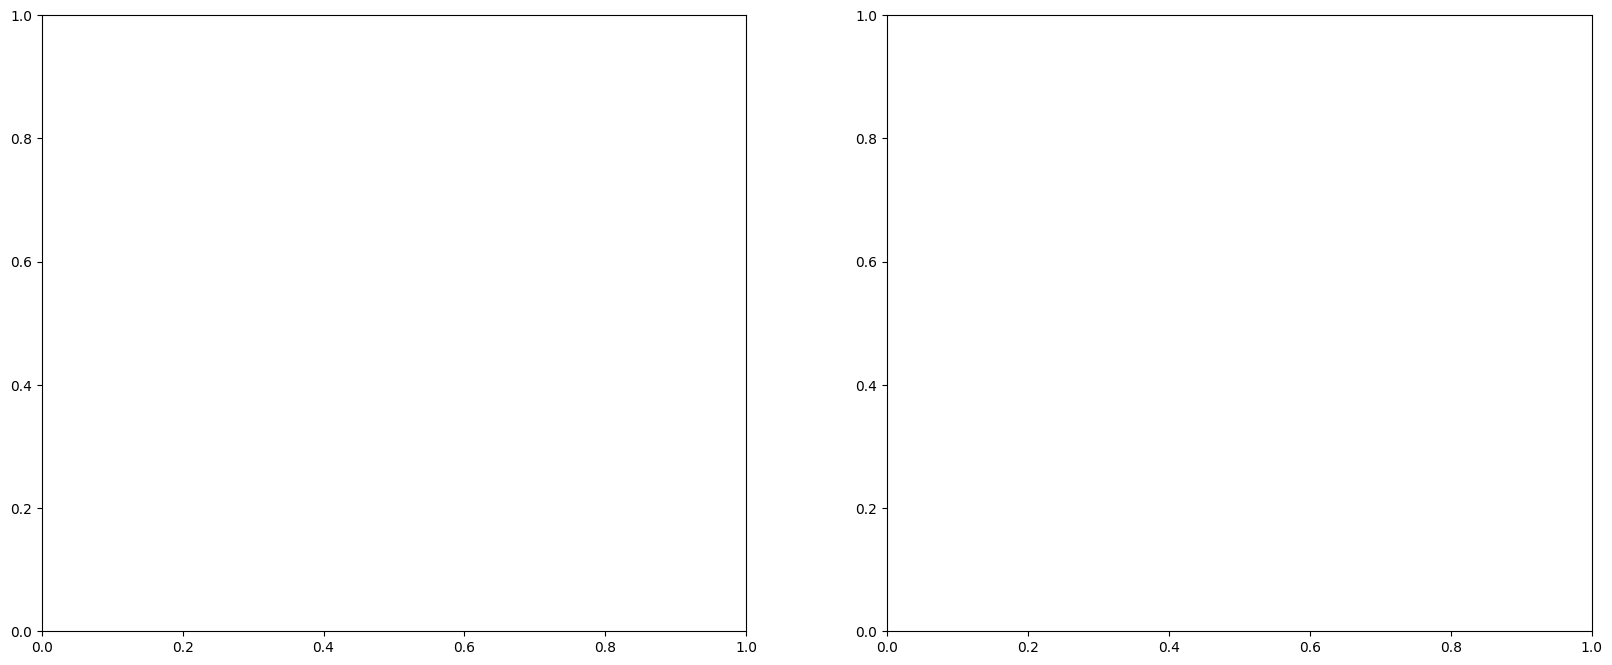

In [2]:
visualize_all_methods()

In [156]:
import jax
import jax.numpy as jnp
import time

def benchmark_split_scenarios_final():
    # 1. INITIALIZATION
    DEGREE = 15
    IN_DIM, OUT_DIM = 100, 100
    key = jax.random.key(42)
    
    # Weight scaling for initialization stability
    weights = jax.random.normal(key, (OUT_DIM, IN_DIM, DEGREE + 1)) * (1.0 / jnp.sqrt(DEGREE + 1))
    
    old_a = jnp.full((IN_DIM,), -1.0)
    old_b = jnp.full((IN_DIM,), 1.0)

    # 2. VECTORIZED WRAPPERS
    def get_vmap(func):
        v = jax.vmap(jax.vmap(func, in_axes=(0, 0, 0, 0, 0, None)), 
                     in_axes=(0, None, None, None, None, None))
        return jax.jit(v, static_argnums=(5,))

    # Method Definitions
    methods = [
        ("No-Refit", get_vmap(lambda w, *args: w)),
        ("LSTSQ (Reference)", get_vmap(lambda *args: cheby_exact_lstsq_refit(*args)[0])),
        ("Summation (Standard)", get_vmap(lambda *args: cheby_summation_refit(*args)[0])),
        ("Summation (Oversampled)", get_vmap(cheby_summation_oversampled_refit)),
        ("Transfer (Soft-Clip)", get_vmap(cheby_transfer_matrix_corrected))
    ]

    v_forward = jax.vmap(jax.vmap(forward_pass, in_axes=(None, 0, 0, 0, None)), 
                         in_axes=(None, 0, None, None, None))

    # 3. EVALUATION
    scenarios = [
        ("EXPANSION", old_a - 0.5, old_b + 0.5), 
        ("SHRINKING", old_a + 0.3, old_b - 0.3)
    ]

    print(f"Final Benchmark: AdaptKAN Layer {OUT_DIM}x{IN_DIM} (D={DEGREE})")

    for scen_name, new_a_vec, new_b_vec in scenarios:
        na, nb = new_a_vec[0], new_b_vec[0]
        oa, ob = old_a[0], old_b[0]
        
        # Grid setup
        x_global = jnp.linspace(na, nb, 1000)
        x_retention = jnp.linspace(oa, ob, 1000) if scen_name == "EXPANSION" else jnp.linspace(na, nb, 1000)
        
        print(f"\nScenario: {scen_name} (New Range: [{na:.2f}, {nb:.2f}])")
        print(f"{'Method':25} | {'Time (ms)':10} | {'Global RMSE':12} | {'Retention RMSE':15}")
        print("-" * 95)

        for name, fn in methods:
            # Benchmark
            _ = fn(weights, old_a, old_b, new_a_vec, new_b_vec, DEGREE)
            jax.block_until_ready(_)
            
            start = time.perf_counter()
            for _ in range(10):
                res_weights = fn(weights, old_a, old_b, new_a_vec, new_b_vec, DEGREE)
                jax.block_until_ready(res_weights)
            avg_time = (time.perf_counter() - start) / 10
            
            # RMSE Metrics
            y_true_glob = v_forward(x_global, weights, old_a, old_b, DEGREE)
            y_pred_glob = v_forward(x_global, res_weights, new_a_vec, new_b_vec, DEGREE)
            rmse_glob = jnp.sqrt(jnp.mean(jnp.square(y_true_glob - y_pred_glob)))
            
            y_true_ret = v_forward(x_retention, weights, old_a, old_b, DEGREE)
            y_pred_ret = v_forward(x_retention, res_weights, new_a_vec, new_b_vec, DEGREE)
            rmse_ret = jnp.sqrt(jnp.mean(jnp.square(y_true_ret - y_pred_ret)))
            
            print(f"{name:25} | {avg_time*1000:10.4f} | {rmse_glob:12.6f} | {rmse_ret:15.8f}")

In [155]:
# Execute the test
benchmark_split_scenarios()

Benchmarking AdaptKAN Layer 100x100 (D=15)

Scenario: EXPANSION (Range: [-1.50, 1.50])
Method                 | Time (ms)  | Global RMSE  | Retention RMSE 
-------------------------------------------------------------------------------------
No-Refit (Scaling)     |     0.0250 |     0.964760 |      0.82226723
LSTSQ (Reference)      |    33.2275 |     0.387367 |      0.44854537
Summation (DCT)        |     0.0924 |     0.447006 |      0.49139723
Transfer (Soft-Clip)   |     0.1239 |     0.917429 |      1.12324190

Scenario: SHRINKING (Range: [-0.70, 0.70])
Method                 | Time (ms)  | Global RMSE  | Retention RMSE 
-------------------------------------------------------------------------------------
No-Refit (Scaling)     |     0.0265 |     0.802954 |      0.80295438
LSTSQ (Reference)      |    31.8709 |     0.000000 |      0.00000046
Summation (DCT)        |     0.0530 |     0.000436 |      0.00043561
Transfer (Soft-Clip)   |     0.1126 |     0.000184 |      0.00018394


## Conclusions: Summation (DCT) with the oversample ratio > 1.0 gives us good speed and accuracy tradeoff

## Adding in constraints